In [1]:
# Importing necessary libraries
import os
import cv2
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.applications import ResNet50

# Importing TensorFlow and Keras modules
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import *  # Importing pretrained models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i][0]])
    plt.show()

2024-04-08 09:00:55.000511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 09:00:55.000642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 09:00:55.161881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Prepare data

In [2]:
IMAGE_SIZE = (128, 128) #loaded images will be scaled to 128x128

### Training data

In [3]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'

training_generator = ImageDataGenerator(
    rescale = 1/255,
    zoom_range=0.1
)

train_data = training_generator.flow_from_directory(train_dir, target_size=IMAGE_SIZE, shuffle=True, batch_size=32, class_mode='binary')
print("Classes: ",train_data.class_indices)

Found 5216 images belonging to 2 classes.
Classes:  {'NORMAL': 0, 'PNEUMONIA': 1}


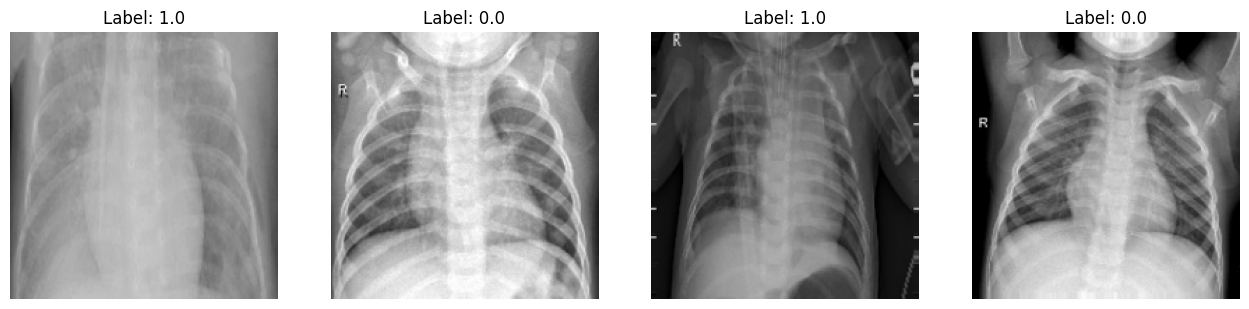

In [106]:
images, labels = next(train_data)

# Display the images
plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title('Label: {}'.format(labels[i]))
    plt.axis('off')
plt.show()

### Validation data

In [4]:
valid_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

validation_generator = ImageDataGenerator(
    rescale = 1/255
)

validation_data = validation_generator.flow_from_directory(valid_dir, target_size=IMAGE_SIZE, shuffle = False, batch_size=4, class_mode='binary')
print("Classes: ",validation_data.class_indices)

Found 16 images belonging to 2 classes.
Classes:  {'NORMAL': 0, 'PNEUMONIA': 1}


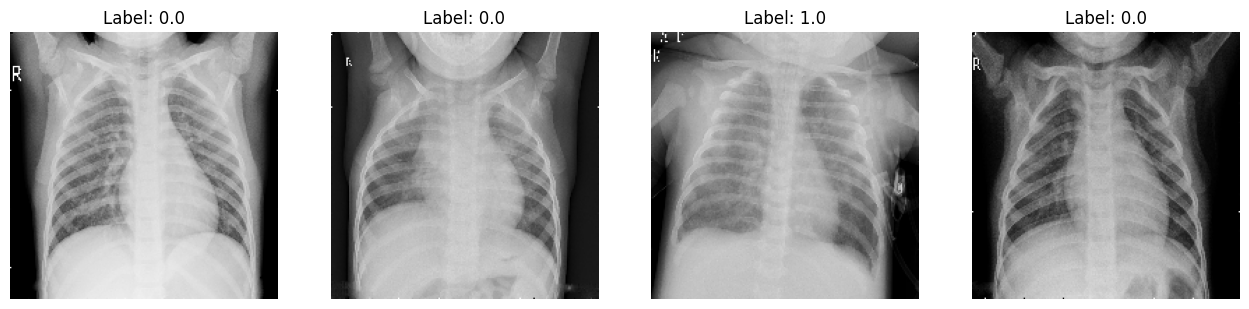

In [108]:
images, labels = next(validation_data)

plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title('Label: {}'.format(labels[i]))
    plt.axis('off')
plt.show()

### Testing data

In [5]:
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
testing_generator = ImageDataGenerator(
    rescale = 1/255,
)

test_data = testing_generator.flow_from_directory(test_dir, target_size=IMAGE_SIZE, shuffle=False, batch_size=4, class_mode='binary')
print("Classes: ",test_data.class_indices)

Found 624 images belonging to 2 classes.
Classes:  {'NORMAL': 0, 'PNEUMONIA': 1}


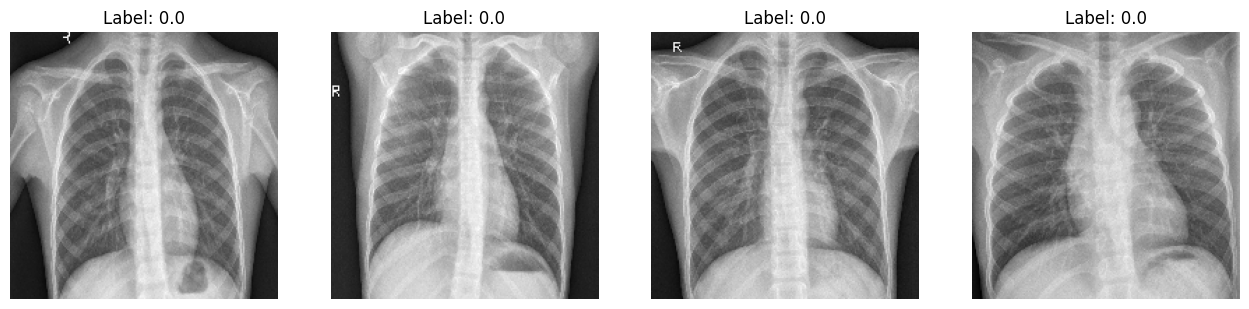

In [110]:
images, labels = next(test_data)

plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title('Label: {}'.format(labels[i]))
    plt.axis('off')
plt.show()

In [121]:
for image_batch, labels_batch in train_data:
    print("Shape of X_train: ", image_batch.shape)  # Shape of the input images
    print("Shape of y_train: ", labels_batch.shape)  # Shape of the labels for these images
    break

#we have 32 samples in each batch with dimensions 128x128 and 3 channels

Shape of X_train:  (32, 128, 128, 3)
Shape of y_train:  (32,)


## Let's take a look at class distribution

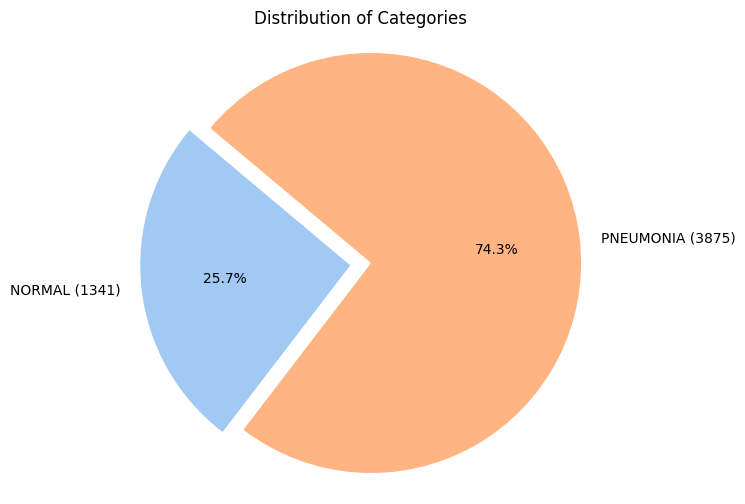

In [11]:
class_counts = train_data.labels
class_indices = train_data.class_indices

# Create a figure with one subplot
plt.figure(figsize=(6, 6), facecolor='white')

# Plot pie chart
palette = sns.color_palette("pastel")
sns.set_palette(palette)
unique, counts = np.unique(class_counts, return_counts=True)
labels = [list(class_indices.keys())[i] + f' ({counts[i]})' for i in unique]

# Define explode - how much each section is separated from the center
explode = (0, 0.1)  # Explode the second slice (PNEUMONIA)

plt.pie(counts, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')

# Show the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [12]:
class_labels = ["NORMAL","PNEUMONIA"]

unique, counts = np.unique(train_data.labels, return_counts=True)

class_weight = {0: counts[0], 1: counts[1]}

print("Class weight: ",class_weight)
print("0 - NORMAL | 1 - PNEUMONIA")

Class weight:  {0: 1341, 1: 3875}
0 - NORMAL | 1 - PNEUMONIA


We need to use class weight to ballance model learning

## Based on class distribution we will focus on f1-score and look at heatmap to evaluate our model.

# Model 1

In [8]:
input_shape=(128, 128, 3)

In [131]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=["accuracy"]
)

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_78 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 124, 124, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,648,353 (10.10 MB)

 Trainable params: 2,647,457 (10.10 MB)

 Non-trainable params: 896 (3.50 KB)

### Training phase

In [132]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=5,          # 5 epochs with no improvement will stop training
                               restore_best_weights=True) 

history = model.fit(
    train_data, 
    epochs=12,
    validation_data=validation_data, 
    class_weight=class_weight,
    callbacks=[early_stopping,model_checkpoint_callback],
    steps_per_epoch=120, #determines the number of steps (batches of samples) to yield from the training dataset before declaring one epoch finished
    validation_steps=30, #determines the number of steps to yield from the validation dataset at the end of each epoch
)

Epoch 1/12
  2/120 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.7500 - loss: 8319.0586  

W0000 00:00:1712246127.673359     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8326 - loss: 2435.2295

W0000 00:00:1712246182.216082     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


120/120 ━━━━━━━━━━━━━━━━━━━━ 67s 461ms/step - accuracy: 0.8329 - loss: 2423.3369 - val_accuracy: 0.5000 - val_loss: 30.1176
Epoch 2/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.9067 - loss: 331.9569 - val_accuracy: 0.5000 - val_loss: 28.3883
Epoch 3/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 56s 444ms/step - accuracy: 0.9020 - loss: 363.7084 - val_accuracy: 0.5000 - val_loss: 28.2329
Epoch 4/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9263 - loss: 305.1906 - val_accuracy: 0.5000 - val_loss: 10.6664
Epoch 5/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 52s 405ms/step - accuracy: 0.9249 - loss: 376.8134 - val_accuracy: 0.5000 - val_loss: 2.8481
Epoch 6/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9416 - loss: 303.0833 - val_accuracy: 0.6250 - val_loss: 1.2558
Epoch 7/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 51s 405ms/step - accuracy: 0.9457 - loss: 289.6748 - val_accuracy: 0.5000 - val_loss: 2.3865
Epoch 8/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.9534 -

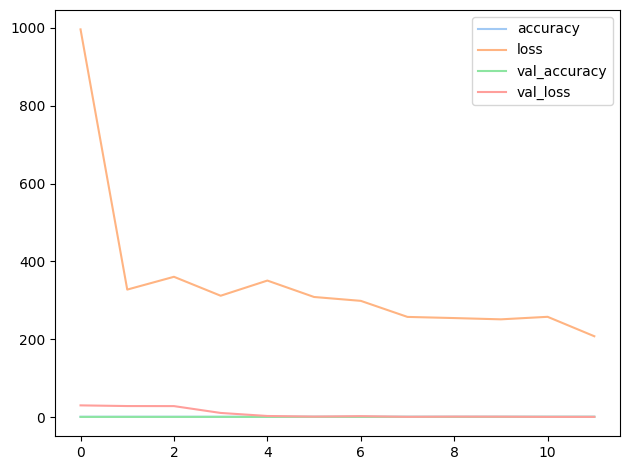

In [135]:
show_history(history)

### Testing phase

In [133]:
# Load best setup
model.load_weights("best.weights.h5")

pred = model.predict(test_data)

pd.DataFrame(classification_report(test_data.classes, pred > 0.5, output_dict=True))

156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step


,0,1,accuracy,macro avg,weighted avg
precision,0.967742,0.728814,0.764423,0.848278,0.818412
recall,0.384615,0.992308,0.764423,0.688462,0.764423
f1-score,0.550459,0.840391,0.764423,0.695425,0.731666
support,234.000000,390.000000,0.764423,624.000000,624.000000


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


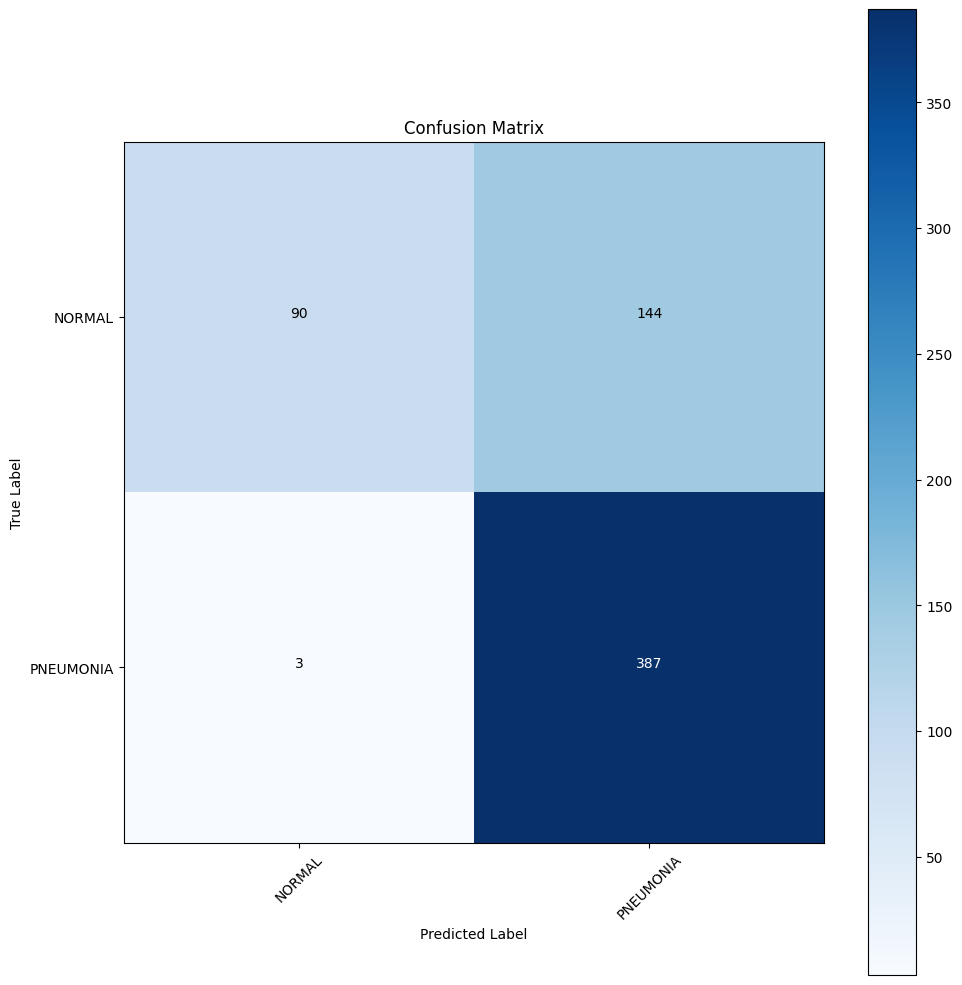

In [134]:
pred = model.predict(test_data)

cm = confusion_matrix(test_data.classes, pred>=0.5) 

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Conclusion

We have a lot of false positive results, but it isn't that bad considering it's better to be labeled positive and then find out you are negative, that labeled negative and later found out you are positive all along. Hope it makes sense :D

So for now we are happy with our model predicting only 3 false negative results and we can move on to try lower the parameters.

# Model 2

Lets try to lower parameters

In [140]:
input_shape=(128, 128, 3)

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_88 (Conv2D)              │ (None, 126, 126, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 61, 61, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │       200,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,801 (807.82 KB)

 Trainable params: 206,801 (807.82 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=5,          # 5 epochs with no improvement will stop training
                               restore_best_weights=True) 

history = model.fit(
    train_data, 
    epochs=12,
    validation_data=validation_data, 
    class_weight=class_weight,
    callbacks=[early_stopping,model_checkpoint_callback],
    steps_per_epoch=120, #determines the number of steps (batches of samples) to yield from the training dataset before declaring one epoch finished
    validation_steps=30, #determines the number of steps to yield from the validation dataset at the end of each epoch
)

Epoch 1/12
  1/120 ━━━━━━━━━━━━━━━━━━━━ 17:46 9s/step - accuracy: 0.6875 - loss: 2013.0757

W0000 00:00:1712246974.401450     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/120 ━━━━━━━━━━━━━━━━━━━━ 58s 413ms/step - accuracy: 0.7643 - loss: 1008.9854 - val_accuracy: 0.6875 - val_loss: 0.5280
Epoch 2/12
  1/120 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9062 - loss: 376.3174

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.8694 - loss: 470.0126 - val_accuracy: 0.6875 - val_loss: 0.4967
Epoch 3/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 48s 376ms/step - accuracy: 0.8748 - loss: 445.6158 - val_accuracy: 0.6875 - val_loss: 0.5701
Epoch 4/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9222 - loss: 365.3305 - val_accuracy: 0.7500 - val_loss: 0.7215
Epoch 5/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 50s 394ms/step - accuracy: 0.9133 - loss: 362.8673 - val_accuracy: 0.5625 - val_loss: 1.6163
Epoch 6/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.9178 - loss: 329.3086 - val_accuracy: 0.7500 - val_loss: 0.3156
Epoch 7/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 46s 365ms/step - accuracy: 0.9304 - loss: 365.5331 - val_accuracy: 0.5625 - val_loss: 1.1754
Epoch 8/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.9341 - loss: 307.5973 - val_accuracy: 0.5625 - val_loss: 1.3712
Epoch 9/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 69s 364ms/step - accuracy: 0.9420 - loss

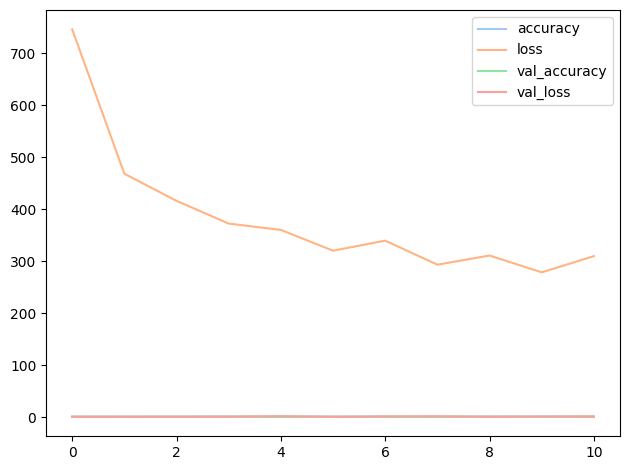

In [142]:
show_history(history)

In [143]:
# Load best setup
model.load_weights("best.weights.h5")

pred = model.predict(test_data)

pd.DataFrame(classification_report(test_data.classes, pred > 0.5, output_dict=True))

156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step


,0,1,accuracy,macro avg,weighted avg
precision,0.950355,0.792961,0.828526,0.871658,0.851983
recall,0.572650,0.982051,0.828526,0.777350,0.828526
f1-score,0.714667,0.877434,0.828526,0.796050,0.816396
support,234.000000,390.000000,0.828526,624.000000,624.000000


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step


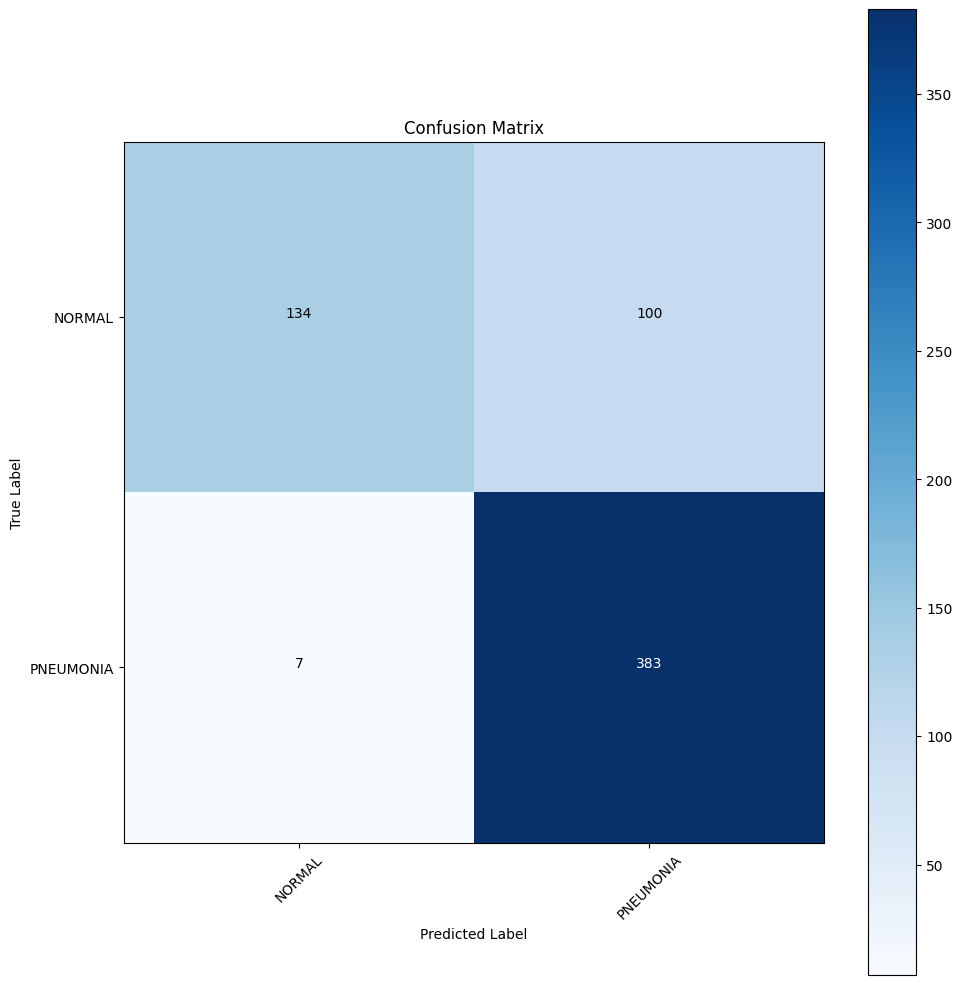

In [144]:
pred = model.predict(test_data)

cm = confusion_matrix(test_data.classes, pred>=0.5) 

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

We ended up with model reaching similar results but with 10 times less parameters. But the false negative results are higher which is not good in this case

# Model 3

Lets try to go even lower with the parameters

In [145]:
input_shape=(128, 128, 3)

model = Sequential()

model.add(Conv2D(filters=4, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_91 (Conv2D)              │ (None, 126, 126, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 63, 63, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 61, 61, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 30, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 28, 28, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,785 (202.29 KB)

 Trainable params: 51,785 (202.29 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=5,          # 5 epochs with no improvement will stop training
                               restore_best_weights=True) 

history = model.fit(
    train_data, 
    epochs=12,
    validation_data=validation_data, 
    class_weight=class_weight,
    callbacks=[early_stopping,model_checkpoint_callback],
    steps_per_epoch=120, #determines the number of steps (batches of samples) to yield from the training dataset before declaring one epoch finished
    validation_steps=30, #determines the number of steps to yield from the validation dataset at the end of each epoch
)

Epoch 1/12
  1/120 ━━━━━━━━━━━━━━━━━━━━ 17:32 9s/step - accuracy: 0.5000 - loss: 2266.5918

W0000 00:00:1712247857.786595     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/120 ━━━━━━━━━━━━━━━━━━━━ 57s 404ms/step - accuracy: 0.7274 - loss: 1280.9689 - val_accuracy: 0.6250 - val_loss: 0.8910
Epoch 2/12
  1/120 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8438 - loss: 792.5682

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.8208 - loss: 669.0465 - val_accuracy: 0.6250 - val_loss: 0.6732
Epoch 3/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 48s 378ms/step - accuracy: 0.8466 - loss: 551.4105 - val_accuracy: 0.5625 - val_loss: 1.3644
Epoch 4/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.8749 - loss: 477.4114 - val_accuracy: 0.6250 - val_loss: 0.8381
Epoch 5/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 46s 359ms/step - accuracy: 0.8863 - loss: 400.6143 - val_accuracy: 0.6250 - val_loss: 0.6776
Epoch 6/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.9046 - loss: 356.0345 - val_accuracy: 0.6875 - val_loss: 0.8677
Epoch 7/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 45s 356ms/step - accuracy: 0.8987 - loss: 343.6393 - val_accuracy: 0.7500 - val_loss: 0.5536
Epoch 8/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.9040 - loss: 342.4919 - val_accuracy: 0.5625 - val_loss: 1.1406
Epoch 9/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 46s 363ms/step - accuracy: 0.9002 - loss

In [ ]:
show_history(history)

In [147]:
# Load best setup
model.load_weights("best.weights.h5")

pred = model.predict(test_data)

pd.DataFrame(classification_report(test_data.classes, pred > 0.5, output_dict=True))

156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step


,0,1,accuracy,macro avg,weighted avg
precision,0.949153,0.758893,0.794872,0.854023,0.830241
recall,0.478632,0.984615,0.794872,0.731624,0.794872
f1-score,0.636364,0.857143,0.794872,0.746753,0.774351
support,234.000000,390.000000,0.794872,624.000000,624.000000


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step


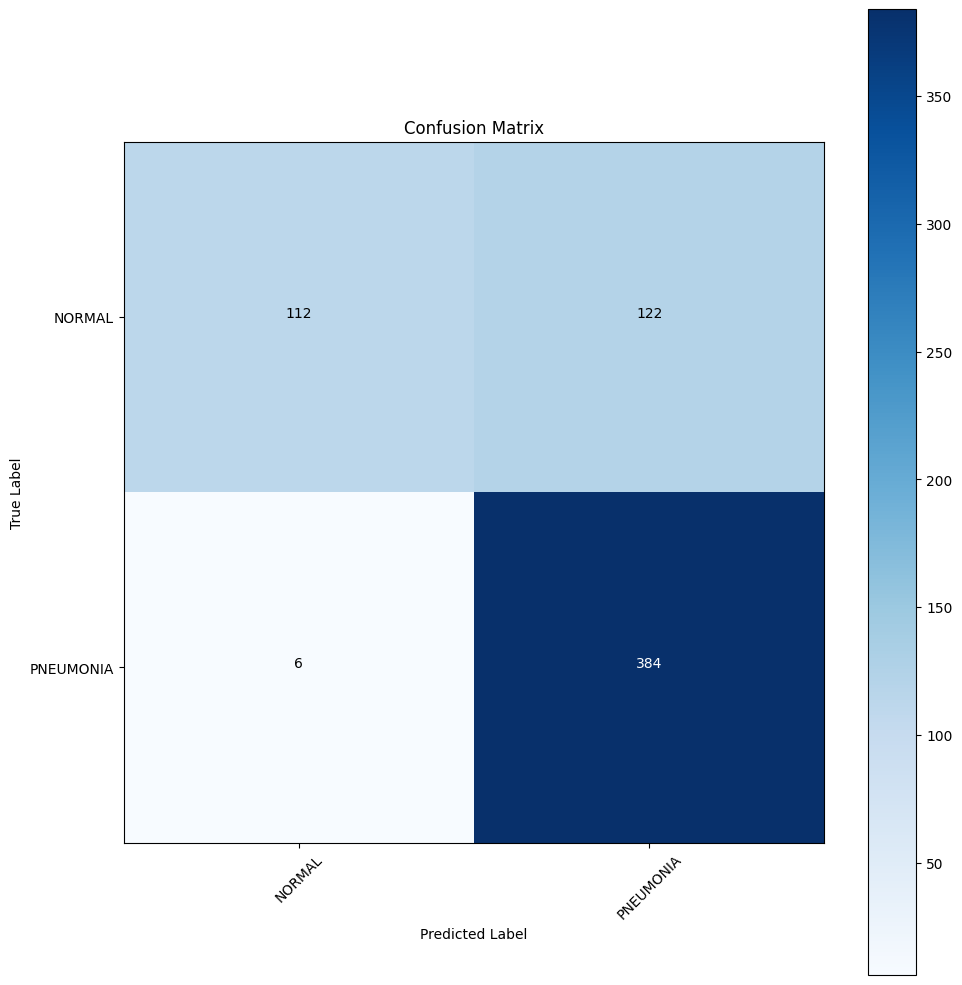

In [149]:
pred = model.predict(test_data)

cm = confusion_matrix(test_data.classes, pred>=0.5) 

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

This model isn't performing badly but we can see the difference between false negative accuracy on this model and the first one .

# Transfer learning

## Xception model

In [150]:
base_model = Xception(weights='imagenet',  
                      include_top=False,   # Exclude the top classification layer so we can alter input_shape
                      pooling='avg',       
                      input_shape=input_shape)  # Input shape of images (128, 128, 3)


base_model.trainable = False

model = Sequential()
model.add(base_model)    # Add Xception base model
model.add(BatchNormalization())
model.add(Dropout(0.40)) # to prevent overfitting randomly drop 40%
model.add(Dense(220, activation='relu'))
model.add(Dropout(0.3))  # to prevent overfitting randomly drop 30%
model.add(Dense(60, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #output layer with 1 for binary classification

model.compile(optimizer=Adamax(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

### Training phase

In [151]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=5,          # 5 epochs with no improvement will stop training
                               restore_best_weights=True) 

history = model.fit(
    train_data, 
    epochs=12,
    validation_data=validation_data, 
    class_weight=class_weight,
    callbacks=[early_stopping,model_checkpoint_callback],
    steps_per_epoch=120, #determines the number of steps (batches of samples) to yield from the training dataset before declaring one epoch finished
    validation_steps=30, #determines the number of steps to yield from the validation dataset at the end of each epoch
)

Epoch 1/12
  2/120 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.6641 - loss: 2057.2686  

W0000 00:00:1712248561.123818     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8532 - loss: 714.2624

W0000 00:00:1712248613.050336     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


120/120 ━━━━━━━━━━━━━━━━━━━━ 71s 442ms/step - accuracy: 0.8535 - loss: 712.8240 - val_accuracy: 0.7500 - val_loss: 0.5571
Epoch 2/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.8903 - loss: 480.3901 - val_accuracy: 0.8125 - val_loss: 0.4961
Epoch 3/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 49s 388ms/step - accuracy: 0.9047 - loss: 451.0099 - val_accuracy: 0.7500 - val_loss: 0.6289
Epoch 4/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.9135 - loss: 387.8843 - val_accuracy: 0.7500 - val_loss: 0.6060
Epoch 5/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 48s 380ms/step - accuracy: 0.9210 - loss: 368.1499 - val_accuracy: 0.7500 - val_loss: 0.7127
Epoch 6/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9255 - loss: 366.4242 - val_accuracy: 0.7500 - val_loss: 0.7515
Epoch 7/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 48s 383ms/step - accuracy: 0.9398 - loss: 325.7580 - val_accuracy: 0.7500 - val_loss: 0.6948


### Testing phase

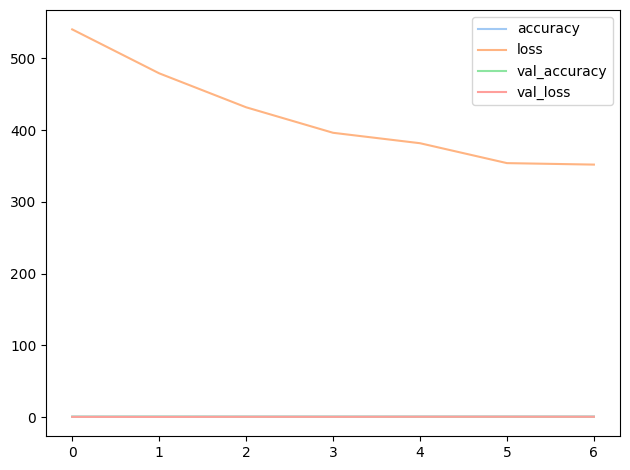

In [152]:
show_history(history)

In [153]:
# Load best setup
model.load_weights("best.weights.h5")

pred = model.predict(test_data)

pd.DataFrame(classification_report(test_data.classes, pred > 0.5, output_dict=True))

  4/156 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step

W0000 00:00:1712248804.960732     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step


,0,1,accuracy,macro avg,weighted avg
precision,0.871166,0.800434,0.81891,0.835800,0.826958
recall,0.606838,0.946154,0.81891,0.776496,0.818910
f1-score,0.715365,0.867215,0.81891,0.791290,0.810271
support,234.000000,390.000000,0.81891,624.000000,624.000000


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step


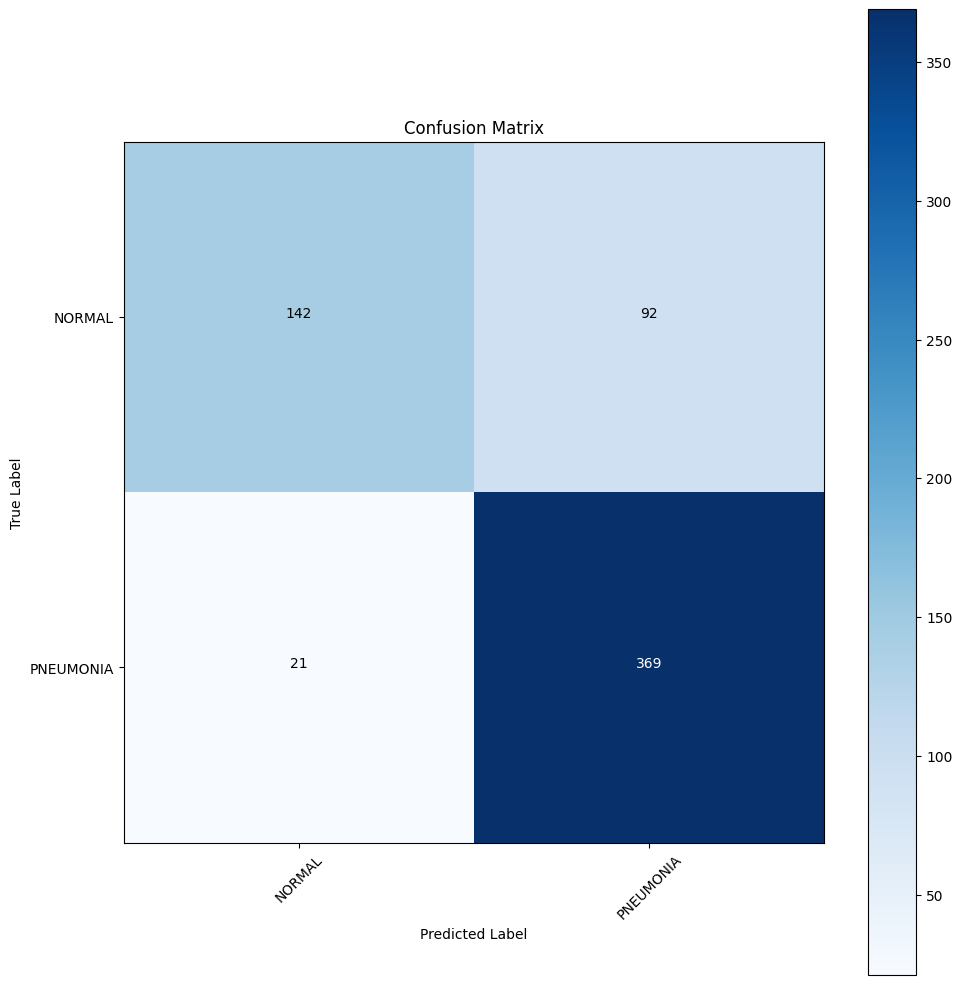

In [154]:
pred = model.predict(test_data)

cm = confusion_matrix(test_data.classes, pred >= 0.5) 

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Not the best results here, we got 21 false negative results on test data. Let's try to Fine-tunne this model

### Fine-tunning

In [157]:
base_model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 220)            │       450,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 60)             │        13,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,333,773 (81.38 MB)

 Trainable params: 21,275,149 (81.16 MB)

 Non-trainable params: 58,624 (229.00 KB)

In [158]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=5,          # 5 epochs with no improvement will stop training
                               restore_best_weights=True) 

history = model.fit(
    train_data, 
    epochs=12,
    validation_data=validation_data, 
    class_weight=class_weight,
    callbacks=[early_stopping,model_checkpoint_callback],
    steps_per_epoch=120, #determines the number of steps (batches of samples) to yield from the training dataset before declaring one epoch finished
    validation_steps=30, #determines the number of steps to yield from the validation dataset at the end of each epoch
)

Epoch 1/12
  1/120 ━━━━━━━━━━━━━━━━━━━━ 1:54:49 58s/step - accuracy: 0.8438 - loss: 728.1702

W0000 00:00:1712248956.165592     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7876 - loss: 984.1838

W0000 00:00:1712249004.435059     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


120/120 ━━━━━━━━━━━━━━━━━━━━ 107s 414ms/step - accuracy: 0.7879 - loss: 982.7725 - val_accuracy: 0.6250 - val_loss: 0.5674
Epoch 2/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.8972 - loss: 501.6484 - val_accuracy: 0.6875 - val_loss: 0.6188
Epoch 3/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 47s 371ms/step - accuracy: 0.8877 - loss: 511.3892 - val_accuracy: 0.6875 - val_loss: 0.9629
Epoch 4/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.9279 - loss: 332.1782 - val_accuracy: 0.6250 - val_loss: 1.0820
Epoch 5/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9194 - loss: 392.0851 - val_accuracy: 0.5625 - val_loss: 1.1395
Epoch 6/12
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.9501 - loss: 324.5427 - val_accuracy: 0.5625 - val_loss: 1.1493


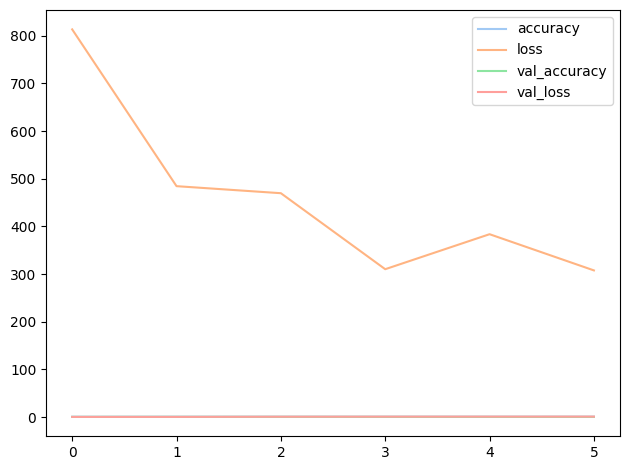

In [159]:
show_history(history)

In [160]:
# Load best setup
model.load_weights("best.weights.h5")

pred = model.predict(test_data)

pd.DataFrame(classification_report(test_data.classes, pred > 0.5, output_dict=True))

  4/156 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step

W0000 00:00:1712249146.996834     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step


,0,1,accuracy,macro avg,weighted avg
precision,0.952000,0.769539,0.80609,0.860770,0.837962
recall,0.508547,0.984615,0.80609,0.746581,0.806090
f1-score,0.662953,0.863892,0.80609,0.763422,0.788540
support,234.000000,390.000000,0.80609,624.000000,624.000000


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step


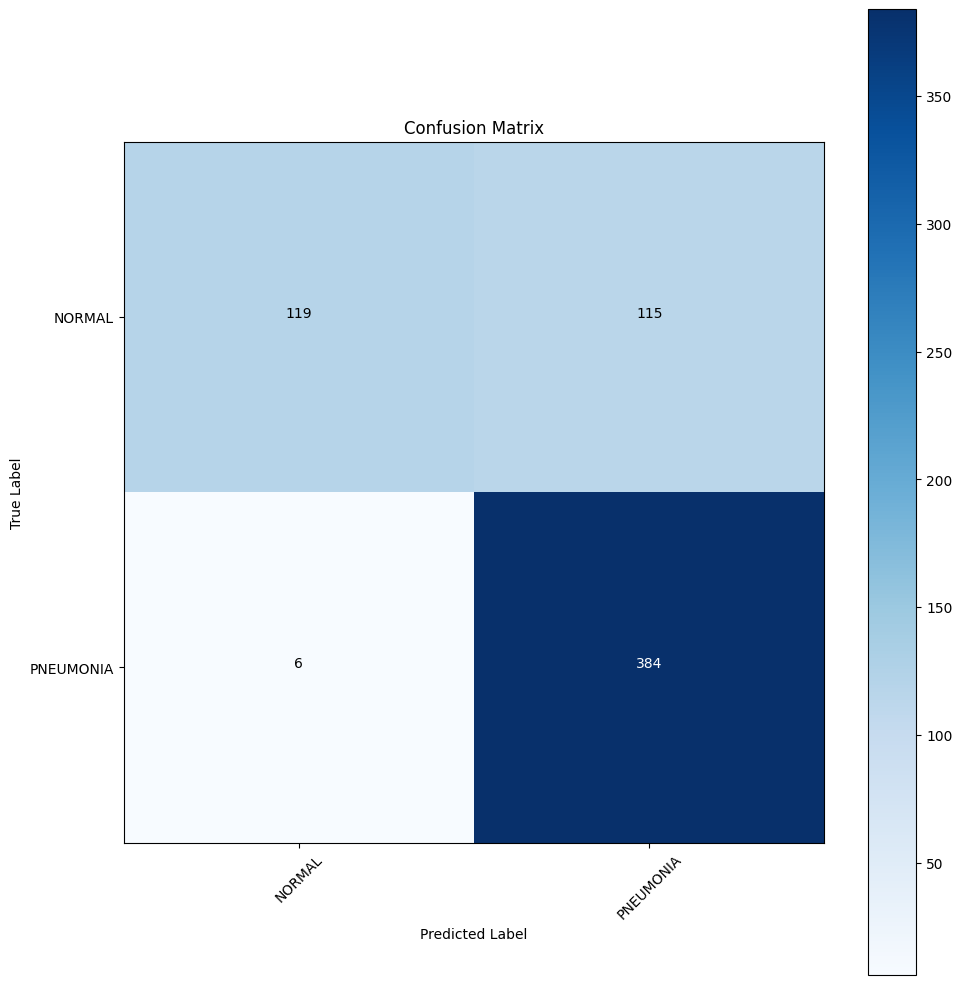

In [161]:
pred = model.predict(test_data)

cm = confusion_matrix(test_data.classes, pred>=0.5) 

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

 Model after Fine-tunning has better results because we got only 6 false negative to previous 21 before Fine-tunning.

# Results

The 1st model with ~2.5 million parameters performed the best, it predicted false negatives in 3 cases out of 624 test data.

The 2nd model with ~206,000 parameters predicted false negatives in 7 cases out of 624 test data.

The 3rd model with ~50,000 parameters predicted false negatives in 6 cases out of 624 test data.

The 4th Xception model (~21 million parameters)

* Before Fine-tunning predicted false negatives in 21 cases out of 624 test data, which is the worst result.
* After Fine-tunning predicted false negatives in 6 cases out of 624 test data, which is the worst result.

**Results:**

Overall the third model performed best when we consider number of parameters and false negative encounters. But when predicting pneumonia we want to minimalise false negative results thats why i would chose the first model because he performed the best on test data.